# SparkDev AI Hurricane Trajectory Prediction

In this project, we'll be using neural networks to predict the trajectory paths of hurricanes in South Florida. We will be using the Hurricane Database dataset from Unisys Weather. Here we will preprocess the data, then train a recurrent neural network on some of the samples. At the end, we'll get to see our neural network's hurricane trajectory path predictions.

### Get and Analyze the Data

[Here's the link containing the entire dataset.](http://weather.unisys.com/hurricane/atlantic/) So far, we're using only the years 2000 to 2009 and is saved on our repo as '2000-2009-data.csv'. We have to get an idea of the hurricanes' behavior to properly create a model for our neural network. 

In [2]:
# ALL THE IMPORTS NECESSARY
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from geopy.distance import great_circle as vc
import math as Math

from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import math, time

from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
data = pd.read_csv('1920-2012-data.csv', index_col=None, names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure', 'NullCol'])

# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)

# Delete the columns of information that we are not using so far
data.drop(['Name', 'HurricaneNum', 'Year', 'NullCol'], axis = 1, inplace = True)

# Preview the first 5 rows of data
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
0,6,7,18,21,-93.0,25.0,0,NOTNAMED-2000-1
1,6,8,0,20.9,-92.8,25.0,0,NOTNAMED-2000-1
2,6,8,6,20.7,-93.1,25.0,0,NOTNAMED-2000-1
3,6,8,12,20.8,-93.5,25.0,0,NOTNAMED-2000-1
4,6,23,0,9.5,-19.8,25.0,0,NOTNAMED-2000-2


In [3]:
# Remove hurricanes where pressure = 0
data = data[data['Pressure'] != 0]
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
16,8,3,18,10.8,-18.0,25.0,1007,ALBERTO-2000-3
17,8,4,0,11.5,-20.1,30.0,1005,ALBERTO-2000-3
18,8,4,6,12,-22.3,35.0,1004,ALBERTO-2000-3
19,8,4,12,12.3,-23.8,35.0,1003,ALBERTO-2000-3
20,8,4,18,12.7,-25.2,40.0,1002,ALBERTO-2000-3


In [4]:
# Total amount of hurricanes we have in our dataset 
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

790


In [5]:
# Finding errors in CSV
print(data[data['Lat'].str.contains("NAMED")])

data = data[~data['Lat'].str.contains("NAMED")]

      Month  Day  Hour    Lat  Long  WindSpeed  Pressure   unique-key
5997      8   31    12  NAMED  37.1      -64.3        25  NOT-2011-20
5998      8   31    18  NAMED  37.1      -64.1        25  NOT-2011-20
5999      9    1     0  NAMED  37.3      -63.9        25  NOT-2011-20
6000      9    1     6  NAMED  37.4      -63.7        30  NOT-2011-20
6001      9    1    12  NAMED  37.4      -63.7        40  NOT-2011-20
6002      9    1    18  NAMED  37.4      -63.8        35  NOT-2011-20
6003      9    2     0  NAMED  37.5      -63.8        35  NOT-2011-20
6004      9    2     6  NAMED  37.8      -63.7        40  NOT-2011-20
6005      9    2    12  NAMED  38.0      -62.8        40  NOT-2011-20
6006      9    2    18  NAMED  39.0      -61.8        35  NOT-2011-20
6007      9    3     0  NAMED  40.0      -60.7        30  NOT-2011-20
6008      9    3     6  NAMED  41.0      -59.9        30  NOT-2011-20
6009      9    3    12  NAMED  42.0      -59.2        30  NOT-2011-20
6010      9    3    

In [6]:
# Total amount of hurricanes we have in our dataset 
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

789


In [7]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

789


In [8]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])
    
# Provides statistical information about the DataFrame 
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

Top 6 Hurricanes (in terms of data quantity)
NADINE-2012-14 - 96.0
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
ALBERTO-2000-3 - 87.0
ARLENE-1987-2 - 81.0
NICHOLAS-2003-19 - 80.0


,0
count,789.000000
mean,20.778200
std,18.740283
min,1.000000
25%,6.000000
50%,15.000000
75%,31.000000
max,96.000000


In [9]:
cond = (hurricane_amount > 6) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]
    
data = data[data['unique-key'].isin(keys25)]
keys = list(enumerate(pd.unique(data['unique-key'])))
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5


In [10]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
FABIAN-1991-9 - 96.0
EMILY-2005-5 - 94.0
DANNY-2003-5 - 90.0
BERYL-2000-5 - 87.0
IRENE-1971-18 - 81.0
HERMINE-2004-8 - 80.0


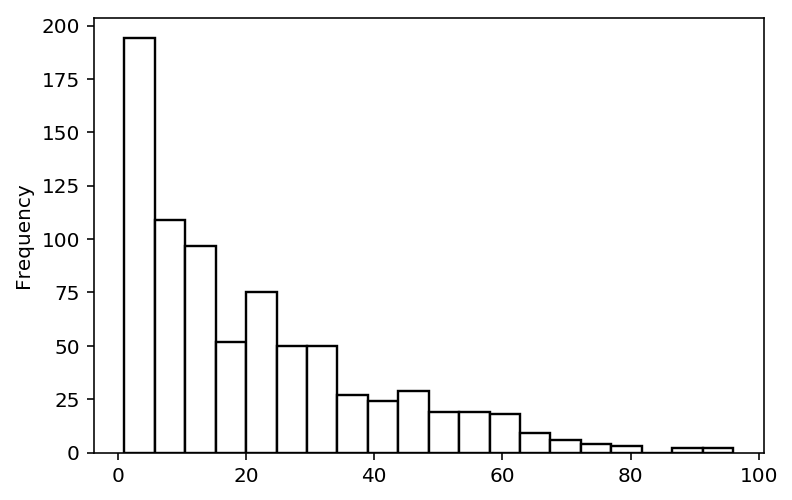

In [11]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [12]:
data.describe()

,Month,Day,Hour,Long,WindSpeed,Pressure
count,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000
mean,8.724621,15.828269,9.186810,-64.398149,50.883939,993.863834
std,1.375840,8.906905,6.729553,20.182565,25.903755,18.023786
min,1.000000,1.000000,0.000000,-109.300000,10.000000,882.000000
25%,8.000000,8.000000,6.000000,-80.700000,30.000000,987.000000
50%,9.000000,16.000000,12.000000,-65.800000,45.000000,1000.000000
75%,10.000000,24.000000,18.000000,-49.500000,65.000000,1007.000000
max,12.000000,31.000000,23.000000,13.500000,165.000000,1024.000000


In [5]:
# Since our keys are strings, we enumerate them to access them as integers 
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
# Now contains how many time instances of data (or rows) each hurricane contains 
hurricane_amount = pd.DataFrame(y)

539


In [7]:
# Total amount of data tuples
total_data_count = len(data)
print(total_data_count)

13131


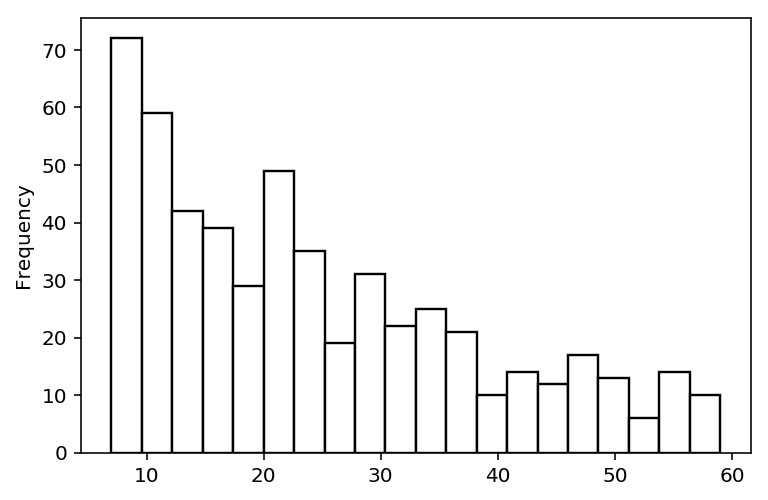

In [15]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
# plt.savefig('frequency_graph', dpi=600)
plt.show()

In [16]:
data.to_csv('checkpoint-dataframe.csv') # Save the dataframe to csv for checkpoint

### Data Preprocessing

From the dataset, we have latitude and longitude. It is easier for the neural network to learn from distance vectors since these values do not contain negative values (like latitude and longitude). To preprocess our data, we will calculate the angle of travel and distance between each given point and add that as new columns to our DataFrame. In addition, we will remove the outlier hurricanes, to get a more normal distribution to insert into the neural network.

In [3]:
data = pd.read_csv('checkpoint-dataframe.csv', index_col=0, header=0)

In [8]:
y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['Lat'], t['Long']):
        
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'distance', vc(prev,p).miles)
        
        dLon = p[1] - prev[1];  
        temp = float(p[0]) # p[0] is a str?
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        data.set_value(t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction', brng)
        dst += vc(prev,p).miles
        prev = p
    y[x] = dst

# Now contains the distance between all given latitude and longitude points
hurricane_distance = pd.DataFrame(y)

In [9]:
# Columns have been added
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction,gridID
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000,1860.0
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.610733,140.567975,1860.0
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.951317,161.351184,1859.0
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.818260,174.302218,1981.0
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.310039,337.250833,1981.0


In [10]:
print(hurricane_distance.shape)

(539, 1)


In [11]:
# Here we can see that the hurricane that traveled the least only traveled 65 miles, while the one that traveled the most traveled 8402 miles
hurricane_distance.describe()

,0
count,539.000000
mean,2171.912334
std,1361.438717
min,86.458593
25%,1087.044690
50%,1872.168005
75%,2952.190796
max,6394.657177


In [12]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])
    
# print(len(hurricane_distance[0]))
# print(len(hurricane_amount[0]))

Top 6 Hurricanes (in terms of distance traveled)
KATE-2003-16 - 6394.65717702 miles - 58.0
BERTHA-1996-2 - 6393.5770538 miles - 51.0
RAFAEL-2012-17 - 6353.52884753 miles - 56.0
BILL-2009-3 - 6238.1751903 miles - 46.0
EARL-2010-7 - 6199.01417969 miles - 55.0
ISAAC-2000-13 - 6158.66324694 miles - 52.0


[[ 1.         0.7385791]
 [ 0.7385791  1.       ]]


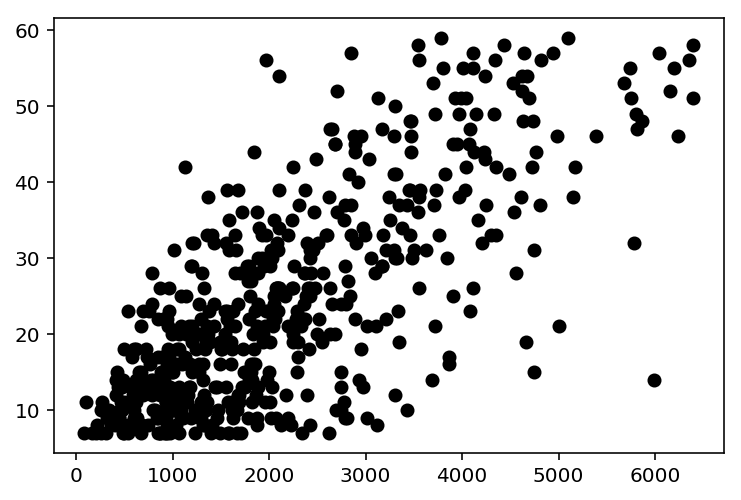

In [13]:
print( np.corrcoef(hurricane_distance[0], hurricane_amount[0]) )
# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
corr = plt.scatter(hurricane_distance[0], hurricane_amount[0], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.show()

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)

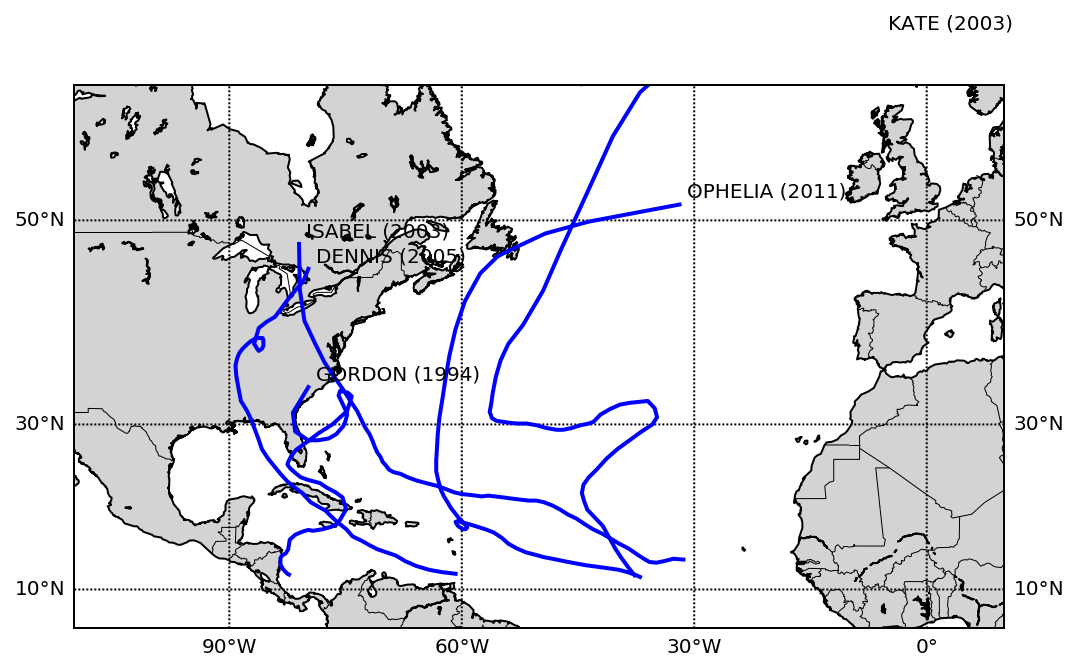

In [24]:
n = 5 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nlargest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('largest_dist_hurricanes')
plt.show()

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)

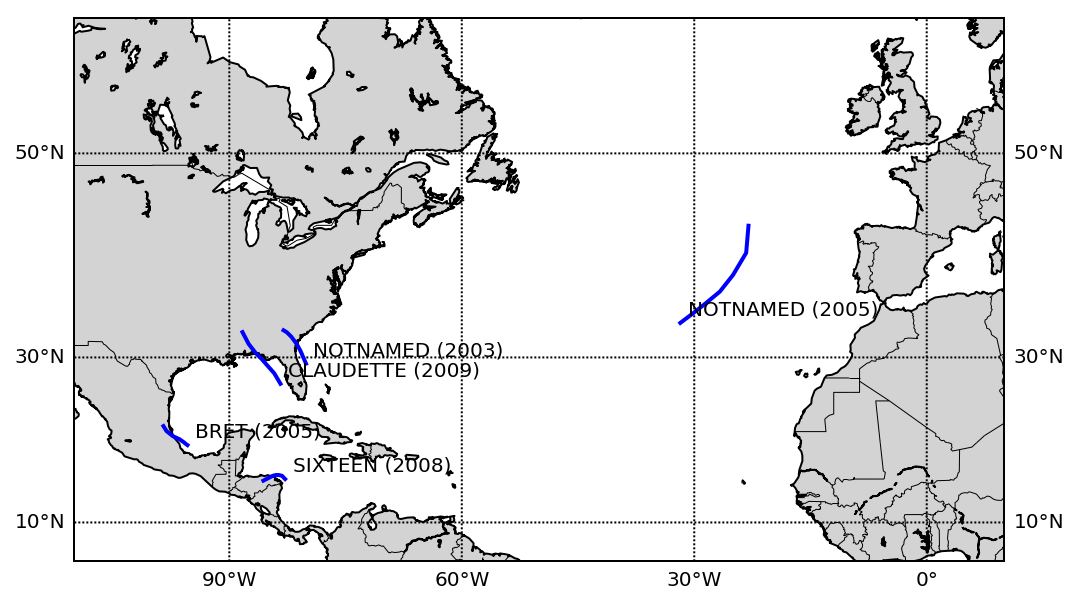

In [25]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nsmallest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Smallest 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('smallest_dist_hurricanes')
plt.show()

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)

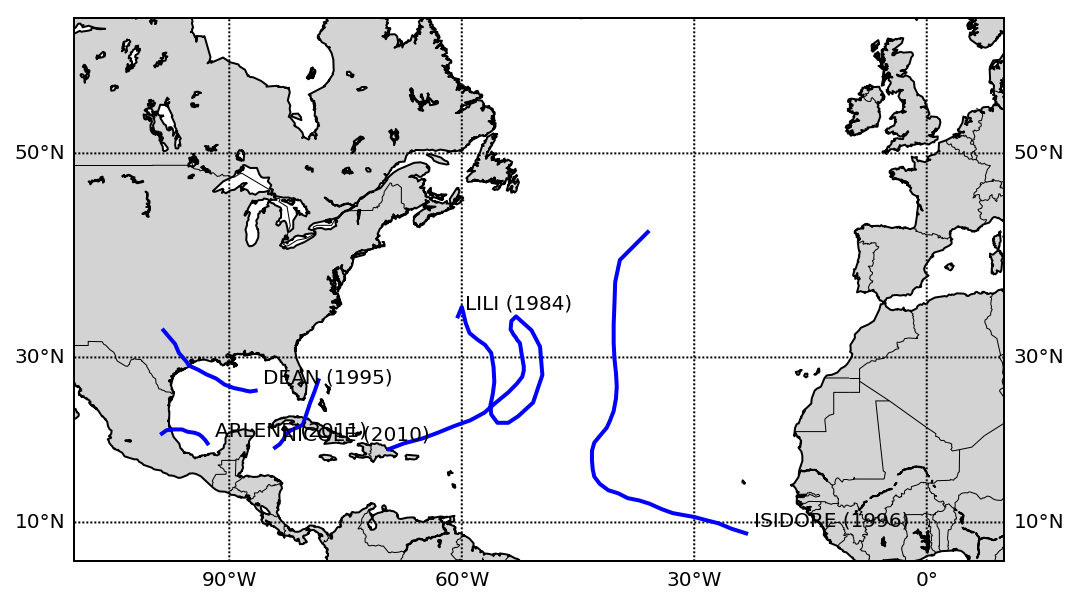

In [26]:
# Graph the trajectories of 3 random hurricanes 
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in np.random.choice(total_hurricane_count, n):
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')
    
# plt.title('Random 5 Atlantic Hurricanes')
# plt.savefig('random_dist_hurricanes')
plt.show()

In [27]:
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.610733,140.567975
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.951317,161.351184
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.818260,174.302218
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.310039,337.250833


In [24]:
import scipy

dist = data[data['distance'] > 0]['distance']
scipy.stats.anderson(dist, dist='norm')

AndersonResult(statistic=814.21599618354048, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

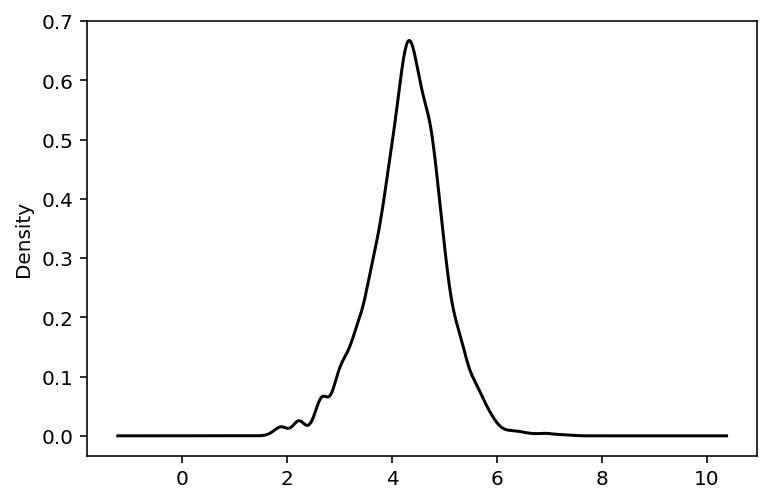

In [40]:
# Distribution of distance traveled in a 6 hour time interval for all hurricanes
dist = np.log(dist)
ser = pd.Series(dist_log)
ser.plot(kind='kde', cmap='gray')
# plt.savefig('distance_dist')

In [27]:
scipy.stats.anderson(dist_log, dist='norm')

AndersonResult(statistic=39.930066824079404, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [39]:
import sklearn 

dist_norm = normalized = (dist-min(dist))/(max(dist)-min(dist))
scipy.stats.anderson(dist_norm, dist='norm')

AndersonResult(statistic=814.21599618353866, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

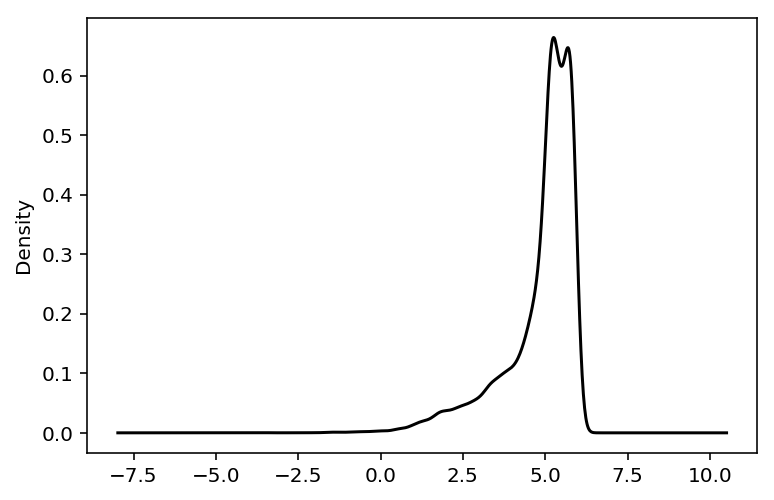

In [29]:
# Distribution of angle traveled in a 6 hour time interval for all hurricanes
direc = data[data['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot(kind='kde', cmap='gray')
# plt.savefig('distance_dist')

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)

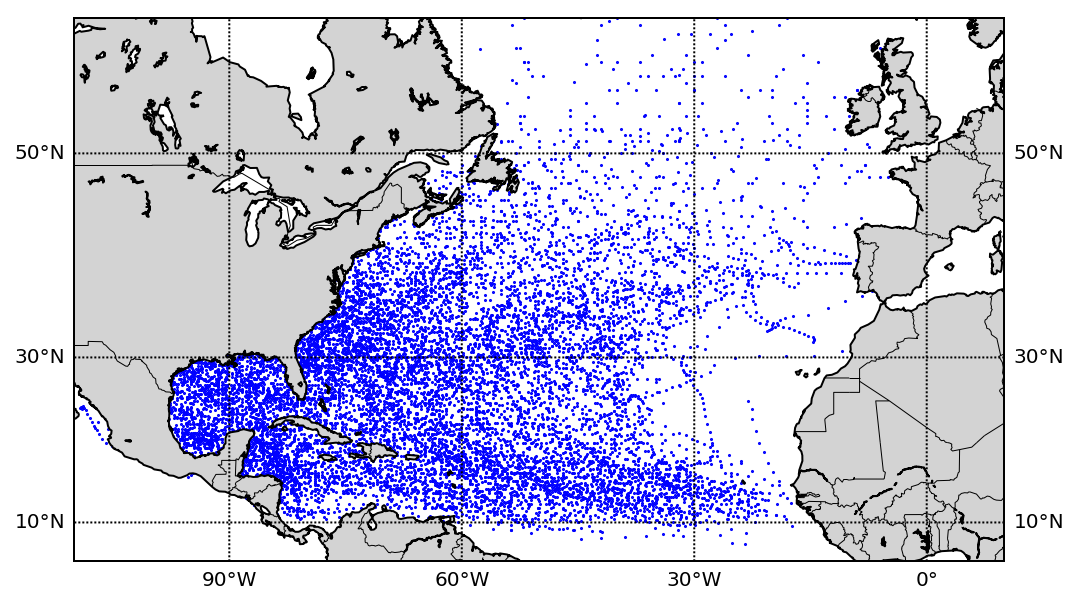

In [30]:
# Graph all points 
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = data['Lat'].values
long = data['Long'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color='blue')

# plt.savefig('scatter_hurricanes')
plt.show()

In [56]:
print(len(xpt))

13131


In [41]:
# Assigning each point to a specific location in the grid. 
# For example, we will learn how a hurricane in quadrant 2 with move.
data['gridID'] = np.zeros(total_data_count)

In [42]:
# These variable are hyperparameters
lat_min = 7.2
long_min = -109.3
lat_interval = round(66 - 7.2)
long_interval = round(13.5 + 109.3)

data['gridID'] = np.floor(data['Lat'] - 7.200)* long_interval  + np.floor(data['Long'] + 109.3)
data['gridID'] = round(data['gridID'])

In [34]:
data.describe()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,distance,direction,gridID
count,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000
mean,8.724621,15.828269,9.186810,26.928840,-64.398149,50.883939,993.863834,89.065295,171.462696,2412.639174
std,1.375840,8.906905,6.729553,9.812459,20.182565,25.903755,18.023786,85.496324,112.500395,1210.856829
min,1.000000,1.000000,0.000000,7.200000,-109.300000,10.000000,882.000000,0.000000,0.000000,64.000000
25%,8.000000,8.000000,6.000000,18.900000,-80.700000,30.000000,987.000000,43.518943,70.936725,1406.000000
50%,9.000000,16.000000,12.000000,26.700000,-65.800000,45.000000,1000.000000,72.774153,177.126694,2374.000000
75%,10.000000,24.000000,18.000000,33.300000,-49.500000,65.000000,1007.000000,111.181166,264.471076,3226.000000
max,12.000000,31.000000,23.000000,66.000000,13.500000,165.000000,1024.000000,1767.320184,359.938162,7256.000000


In [35]:
data.to_csv('checkpoint-dataframe.csv') # Save the dataframe to csv for checkpoint

### Build the Model

In [77]:
data = pd.read_csv('checkpoint-dataframe.csv', index_col=0) 

In [78]:
data.head() # Check loaded data

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction,gridID
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000,1860.0
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.610733,140.567975,1860.0
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.951317,161.351184,1859.0
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.818260,174.302218,1981.0
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.310039,337.250833,1981.0


In [79]:
names = data['unique-key'].unique()
data.drop(['Month', 'Day', 'Hour', 'Lat', 'Long'], axis = 1, inplace = True)
data.head()

,WindSpeed,Pressure,unique-key,distance,direction,gridID
116,30.0,1008,BERYL-2000-5,0.000000,0.000000,1860.0
117,30.0,1008,BERYL-2000-5,23.610733,140.567975,1860.0
118,35.0,1007,BERYL-2000-5,57.951317,161.351184,1859.0
119,40.0,1009,BERYL-2000-5,57.818260,174.302218,1981.0
120,45.0,1009,BERYL-2000-5,63.310039,337.250833,1981.0


In [84]:
np.array(data)

array([[30.0, 1008, 'BERYL-2000-5', 0.0, 0.0, 1860.0],
       [30.0, 1008, 'BERYL-2000-5', 23.61073349715885, 140.56797538055898,
        1860.0],
       [35.0, 1007, 'BERYL-2000-5', 57.95131663430765, 161.35118414564937,
        1859.0],
       ..., 
       [70.0, 975, 'NOTNAMED-1929-2', 480.05475085349633,
        32.902723473217954, 2852.0],
       [60.0, 975, 'NOTNAMED-1929-2', 22.61694216287968,
        19.576091043963004, 2852.0],
       [55.0, 986, 'NOTNAMED-1929-2', 82.49149310005015, 58.54528785490512,
        2854.0]], dtype=object)

In [90]:
np.unique(data['unique-key'])

array(['ABBY-1968-1', 'AGNES-1972-2', 'ALBERTO-1982-1', 'ALBERTO-1988-1',
       'ALBERTO-1994-1', 'ALBERTO-2006-1', 'ALBERTO-2012-1', 'ALEX-1998-1',
       'ALEX-2004-1', 'ALEX-2010-1', 'ALICE-1973-4', 'ALICIA-1983-3',
       'ALLEN-1980-4', 'ALLISON-1989-2', 'ALLISON-1995-1',
       'ALLISON-2001-1', 'ALMA-1962-1', 'ALMA-1966-1', 'ALMA-1970-1',
       'ALPHA-1972-1', 'ALPHA-2005-26', 'AMY-1975-2', 'ANA-1979-2',
       'ANA-1985-1', 'ANA-1991-1', 'ANA-1997-2', 'ANA-2003-1',
       'ANA-2009-2', 'ANDREA-2007-1', 'ANDREW-1986-1', 'ANDREW-1992-4',
       'ANITA-1977-5', 'ANNA-1961-1', 'ANNA-1969-6', 'ANNA-1976-6',
       'ARLENE-1963-1', 'ARLENE-1967-11', 'ARLENE-1981-3', 'ARLENE-1993-2',
       'ARLENE-1999-1', 'ARLENE-2005-1', 'ARLENE-2011-1', 'ARTHUR-1984-6',
       'ARTHUR-1990-2', 'ARTHUR-1996-1', 'ARTHUR-2002-1', 'ARTHUR-2008-1',
       'BABE-1977-6', 'BARRY-1983-4', 'BARRY-1989-3', 'BARRY-1995-2',
       'BARRY-2001-3', 'BARRY-2007-2', 'BECKY-1970-2', 'BELLE-1976-7',
       'BERTH

In [126]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [127]:
data_pad[0:3]

[       WindSpeed  Pressure    distance   direction  gridID
 21217       30.0      1005    0.000000    0.000000  1376.0
 21220       40.0      1002  191.052597  230.915394  1746.0
 21221       45.0       997   73.146159  248.497817  1870.0
 21222       60.0       999   71.707039  348.773839  1993.0
 21223       65.0       999   85.073972   14.434896  2116.0
 21225       65.0       994   45.539207   17.180714  2117.0
 21226       60.0       993   54.439266   18.917150  2240.0
 21227       55.0       992   90.742943  350.544696  2364.0
 21230       50.0       994  110.858535  292.193468  2488.0
 21232       50.0       965   47.499844  321.421596  2489.0
 21233       50.0       997   18.446980  348.103154  2489.0
 21237       50.0       999  201.147210  223.305339  2856.0,
        WindSpeed  Pressure    distance   direction  gridID
 15374       30.0      1001    0.000000    0.000000  1498.0
 15376       40.0       998   51.955774  147.232643  1499.0
 15384       65.0       986  265.430440

In [137]:
len(data)
len(data_pad)
len_vals = []
for x in range(len(data_pad)):
    len_vals += [len(data_pad[x])]
print(max(len_vals))

59


In [139]:
import keras 
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=59, dtype='int32', padding='pre', truncating='pre', value=0.0)

In [142]:
padded_data[3]

array([[   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,

In [52]:
max(data['gridID']) # Total grid spots

7256.0

In [143]:
# Normalize the values to predict them more easily in our model
scalers = {}
gridScalers = {}
for name in names:
    scalers[name] = MinMaxScaler(feature_range=(0, 1))
    gridScalers[name] = MinMaxScaler(feature_range=(0, 1))
    gridScalers[name].fit_transform((data[data['unique-key'] == name])['gridID'].reshape(-1,1))
    hurricane = data[data['unique-key'] == name]
    hurricane.drop('unique-key', axis = 1, inplace= True)
    
    hurricane = pd.DataFrame(scalers[name].fit_transform(hurricane), columns=['WindSpeed',
                                                                              'Pressure',
                                                                              'distance',
                                                                              'direction', 
                                                                              'gridID'])
    data.loc[data['unique-key'] == name, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']] = hurricane.values

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [144]:
data.head()

,WindSpeed,Pressure,unique-key,distance,direction,gridID
116,0.25,0.2,BERYL-2000-5,0.000000,0.000000,0.002747
117,0.25,0.2,BERYL-2000-5,0.302926,0.412575,0.002747
118,0.50,0.0,BERYL-2000-5,0.743516,0.473574,0.000000
119,0.75,0.4,BERYL-2000-5,0.741808,0.511586,0.335165
120,1.00,0.4,BERYL-2000-5,0.812268,0.989849,0.335165


In [145]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['WindSpeed', 'Pressure', 'distance', 'direction', 'gridID']]]

In [149]:
data_pad[1]

,WindSpeed,Pressure,distance,direction,gridID
15374,0.000000,1.000000,0.000000,0.000000,0.000000
15376,0.222222,0.875000,0.160248,0.410819,0.000385
15384,0.777778,0.375000,0.818671,0.037548,0.189908
15385,0.777778,0.250000,0.214049,0.531265,0.237288
15386,1.000000,0.208333,0.255799,0.502249,0.284669
15387,1.000000,0.041667,0.255799,0.502249,0.379430
15388,1.000000,0.041667,0.277115,0.000000,0.426810
15389,0.777778,0.250000,0.235221,1.000000,0.474191
15391,0.000000,0.541667,0.417785,0.232419,0.569337
15393,0.000000,0.625000,0.468836,0.031535,0.617488


In [150]:
padded_data = keras.preprocessing.sequence.pad_sequences(data_pad, maxlen=59, dtype='float', padding='pre', truncating='pre', value=0.0)

In [151]:
padded_data[0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0. 

In [162]:
print(len(padded_data[0]))
print(len(padded_data))

59
539


In [54]:
data[data['unique-key'] == 'BERYL-2000-5'].describe()

In [ ]:
data.drop('unique-key', axis = 1, inplace = True)

In [158]:
def load_data(stock, seq_len, amount_of_features):
#     amount_of_features = len(stock.columns)
#     data = stock.as_matrix() 
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(stock) - sequence_length):
        seq = stock[index: index + sequence_length]
        result.append(seq)
    
    result = np.array(result)
    row = len(result) * 0.85 # Amount of data to train on    
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [56]:
def build_model(layers):
    model = Sequential()

    for x in range(0,3):
        model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
        model.add(Dropout(0.1))

    model.add(LSTM(layers[2], return_sequences=False)) 
    model.add(Dropout(0.1))

    model.add(Dense(output_dim=layers[2]))
    model.add(Activation("tanh"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

### Train the Model

In [159]:
seq_len = 59 # Another hyperparameter- length of hurricane?
feature_count = 5
X_train, y_train, X_test, y_test = load_data(padded_data[::-1], seq_len, feature_count)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

ValueError: cannot reshape array of size 7083835 into shape (407,59,5)

In [58]:
model = build_model([5, window, 1])

/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=5)`
  """


Compilation Time :  0.028970956802368164


/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  # This is added back by InteractiveShellApp.init_path()


In [59]:
model.fit(X_train, y_train, batch_size=512, epochs=200, validation_split=0.1, verbose=1)

Train on 10040 samples, validate on 1116 samples
Epoch 1/200
10040/10040 [==============================] - 4s - loss: 0.2691 - acc: 0.0509 - val_loss: 0.2262 - val_acc: 0.0484
Epoch 2/200
10040/10040 [==============================] - 1s - loss: 0.2078 - acc: 0.0509 - val_loss: 0.1715 - val_acc: 0.0484
Epoch 3/200
10040/10040 [==============================] - 1s - loss: 0.1620 - acc: 0.0509 - val_loss: 0.1310 - val_acc: 0.0484
Epoch 4/200
10040/10040 [==============================] - 1s - loss: 0.1333 - acc: 0.0509 - val_loss: 0.1091 - val_acc: 0.0484
Epoch 5/200
10040/10040 [==============================] - 1s - loss: 0.1230 - acc: 0.0509 - val_loss: 0.1009 - val_acc: 0.0484
Epoch 6/200
10040/10040 [==============================] - 1s - loss: 0.1197 - acc: 0.0514 - val_loss: 0.0973 - val_acc: 0.0484
Epoch 7/200
10040/10040 [==============================] - 1s - loss: 0.1132 - acc: 0.0532 - val_loss: 0.0927 - val_acc: 0.0484
Epoch 8/200
10040/10040 [==============================

10040/10040 [==============================] - 1s - loss: 0.0326 - acc: 0.0839 - val_loss: 0.0139 - val_acc: 0.0789
Epoch 65/200
10040/10040 [==============================] - 1s - loss: 0.0319 - acc: 0.0848 - val_loss: 0.0143 - val_acc: 0.0797
Epoch 66/200
10040/10040 [==============================] - 1s - loss: 0.0321 - acc: 0.0839 - val_loss: 0.0142 - val_acc: 0.0789
Epoch 67/200
10040/10040 [==============================] - 1s - loss: 0.0311 - acc: 0.0854 - val_loss: 0.0136 - val_acc: 0.0797
Epoch 68/200
10040/10040 [==============================] - 1s - loss: 0.0309 - acc: 0.0854 - val_loss: 0.0135 - val_acc: 0.0797
Epoch 69/200
10040/10040 [==============================] - 1s - loss: 0.0310 - acc: 0.0857 - val_loss: 0.0129 - val_acc: 0.0797
Epoch 70/200
10040/10040 [==============================] - 1s - loss: 0.0297 - acc: 0.0860 - val_loss: 0.0126 - val_acc: 0.0815
Epoch 71/200
10040/10040 [==============================] - 1s - loss: 0.0309 - acc: 0.0853 - val_loss: 0.0126

10040/10040 [==============================] - 1s - loss: 0.0251 - acc: 0.0895 - val_loss: 0.0092 - val_acc: 0.0815
Epoch 128/200
10040/10040 [==============================] - 1s - loss: 0.0255 - acc: 0.0887 - val_loss: 0.0097 - val_acc: 0.0815
Epoch 129/200
10040/10040 [==============================] - 1s - loss: 0.0252 - acc: 0.0903 - val_loss: 0.0094 - val_acc: 0.0815
Epoch 130/200
10040/10040 [==============================] - 1s - loss: 0.0254 - acc: 0.0893 - val_loss: 0.0094 - val_acc: 0.0815
Epoch 131/200
10040/10040 [==============================] - 1s - loss: 0.0251 - acc: 0.0894 - val_loss: 0.0094 - val_acc: 0.0815
Epoch 132/200
10040/10040 [==============================] - 1s - loss: 0.0246 - acc: 0.0901 - val_loss: 0.0097 - val_acc: 0.0815
Epoch 133/200
10040/10040 [==============================] - 1s - loss: 0.0237 - acc: 0.0902 - val_loss: 0.0094 - val_acc: 0.0815
Epoch 134/200
10040/10040 [==============================] - 1s - loss: 0.0251 - acc: 0.0909 - val_loss:

10040/10040 [==============================] - 1s - loss: 0.0236 - acc: 0.0888 - val_loss: 0.0098 - val_acc: 0.0815
Epoch 191/200
10040/10040 [==============================] - 1s - loss: 0.0237 - acc: 0.0895 - val_loss: 0.0096 - val_acc: 0.0815
Epoch 192/200
10040/10040 [==============================] - 1s - loss: 0.0234 - acc: 0.0904 - val_loss: 0.0097 - val_acc: 0.0815
Epoch 193/200
10040/10040 [==============================] - 1s - loss: 0.0236 - acc: 0.0897 - val_loss: 0.0098 - val_acc: 0.0815
Epoch 194/200
10040/10040 [==============================] - 1s - loss: 0.0237 - acc: 0.0894 - val_loss: 0.0096 - val_acc: 0.0815
Epoch 195/200
10040/10040 [==============================] - 1s - loss: 0.0234 - acc: 0.0896 - val_loss: 0.0096 - val_acc: 0.0815
Epoch 196/200
10040/10040 [==============================] - 1s - loss: 0.0229 - acc: 0.0918 - val_loss: 0.0098 - val_acc: 0.0815
Epoch 197/200
10040/10040 [==============================] - 1s - loss: 0.0235 - acc: 0.0904 - val_loss:

In [60]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.10 RMSE)
Test Score: 0.01 MSE (0.11 RMSE)


In [61]:
#SAVING MODEL

# Serialize model to JSON
model_json = model.to_json()
with open("model_sheils.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_sheils.h5")
print("Saved Model to Disk")

Saved Model to Disk


### Predicting Hurricane Trajectory

In [62]:
# Load json and create model
json_file = open('model_sheils.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model_sheils.h5")
print("Loaded Model from Disk")
model = loaded_model

# Evaluate loaded model on test data
#loaded_model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded Model from Disk


In [63]:
pred = model.predict(X_test)

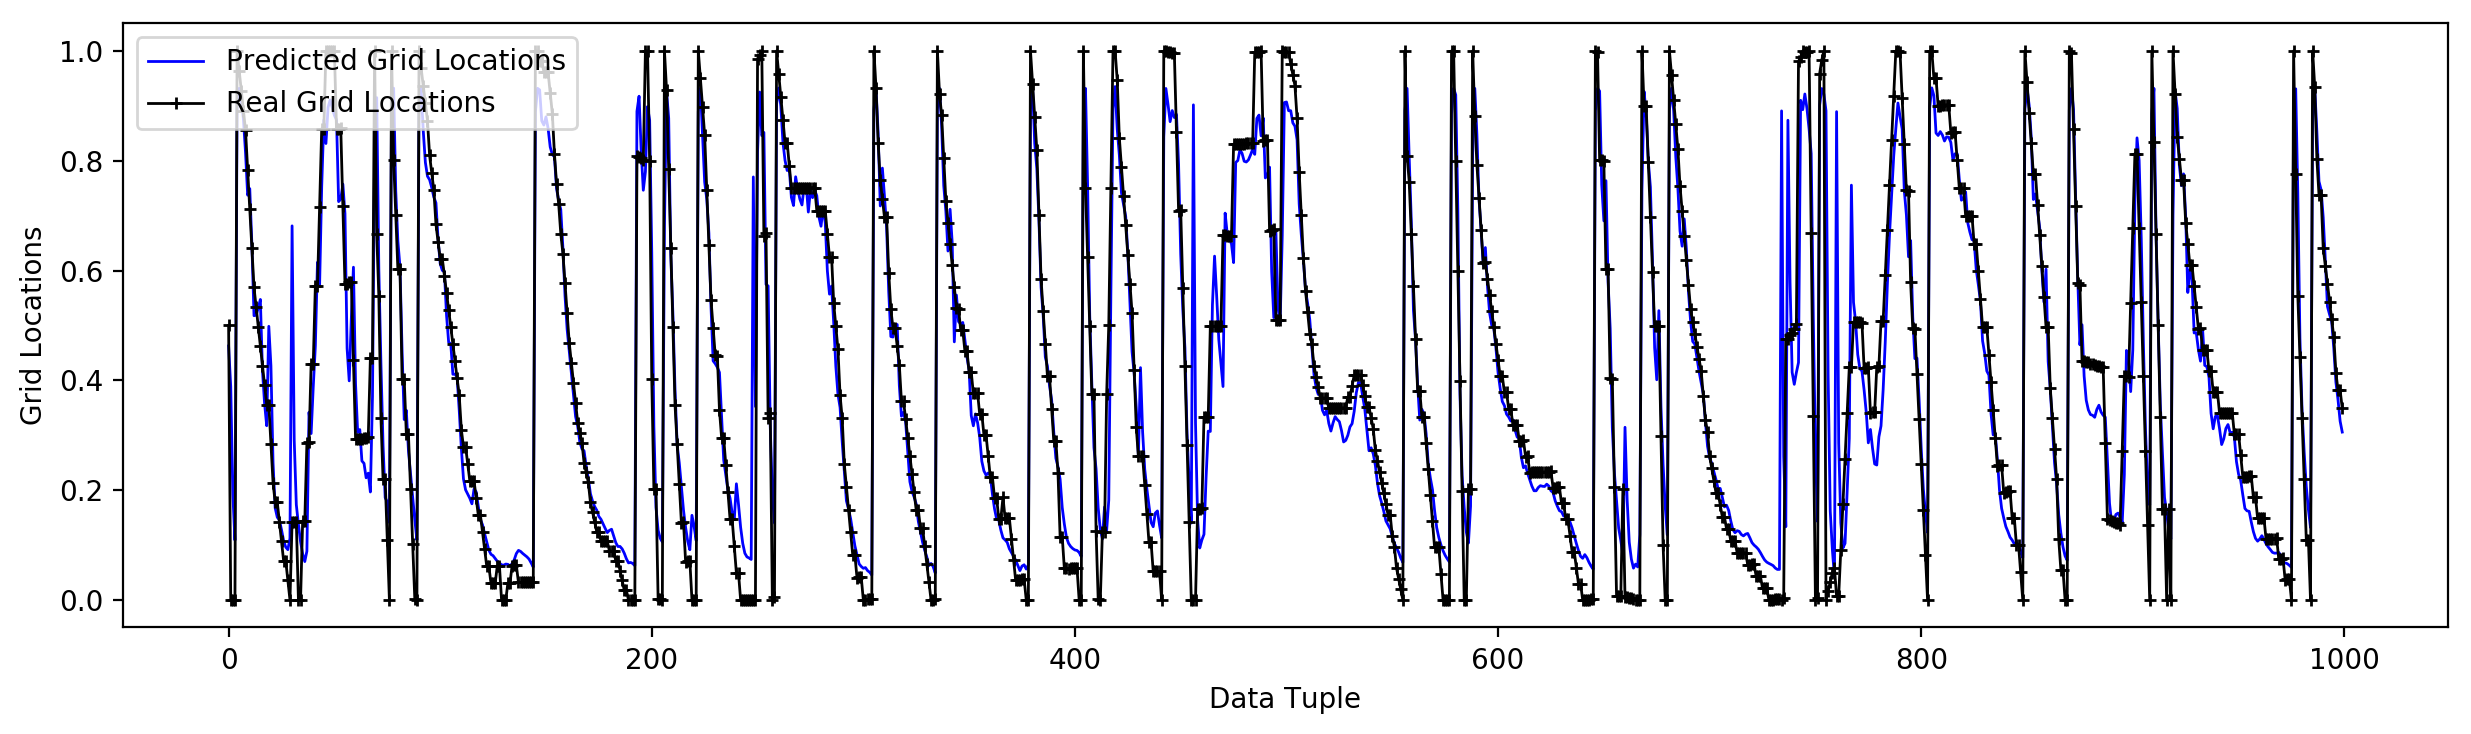

In [64]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:1000],
         linewidth=1, 
         color='blue', 
         label='Predicted Grid Locations')
plt.plot(y_test[:1000],
         linewidth=1, 
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
# plt.savefig('grid_accuracy.png')
plt.show()

In [73]:
pred_test = model.predict(X_test)

In [72]:
from sklearn.preprocessing import MinMaxScaler

def grid2coord(grid):
    y = np.floor(grid/long_interval) #y_coord
    x = np.floor(grid-y*long_interval) #x_coord
    #x and y represent the bottom left corner of the grid
    return (x+0.5+long_min, y+0.5+lat_min)

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    return vector

def load_hurricane(stock, seq_len):#load a single hurricane
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(data) - sequence_length):
        seq = data[index: index + sequence_length]
        result.append(seq)
                
    result = np.array(result)
    result = result[:,:-1]
    return np.reshape(result, (result.shape[0], result.shape[1], amount_of_features))

def prep_hurricane(hurr, name):
    hurr.drop(['Month', 'Day', 'Hour', 'Lat', 'Long', 'unique-key'], axis = 1, inplace = True)
    hurr = hurr[hurr['distance'] > 0]

    hurr['distance'] = np.log(hurr['distance'])

    hurr = hurr[hurr['direction'] > 0]
    hurr['direction'] = np.log(hurr['direction'])
    return pd.DataFrame(scalers[name].fit_transform(hurr), columns=['WindSpeed', 'Pressure', 'Distance', 'Direction', 'gridID'])
    
def test():
    data = pd.read_csv('checkpoint-dataframe.csv', index_col=0, header=0)
    name = 'MICHAEL-2000-17' # Hurricane Key

    window = 5
    hurricane = prep_hurricane(data[data['unique-key'] == name], name) # This is good

    hurr_data = load_hurricane(hurricane[::-1], window)
    return hurr_data.shape
print(test())

(13, 5, 5)


/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
# # This code doesn't graph the trajectories properly. 
# # Very large error when converting back to latitude and longitude points. 
# # To be improved later. 

# from mpl_toolkits.basemap import Basemap
# import matplotlib.cm as cm

# window = 5

# # Graph the trajectories of the longest hurricanes (the ones that traveled the most)
# data = pd.read_csv('checkpoint-dataframe.csv', index_col=0, header=0)
# for x in data['unique-key'].unique():
    
#     if len(data[data['unique-key'] == x]) < 10:
#         continue
#     hurricane = prep_hurricane(data[data['unique-key'] == x], x)
#     hurr_data = load_hurricane(hurricane, window)

#     plt.figure(figsize=(10,5))
#     m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
#                 rsphere=(6378137.00,6356752.3142),
#                 resolution='l',
#                 projection='merc',
#                 lat_0=40.,lon_0=-20.,lat_ts=20.)
#     m.drawcoastlines()
#     m.drawcountries()
#     m.drawmapboundary(fill_color='white')
#     m.fillcontinents(color='#D3D3D3')
#     m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
#     m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

#     hurricane_temp = hurricane['gridID']
#     hurricane_temp = hurricane_temp.reshape(-1, 1)

#     pred = model.predict(hurr_data)
#     back2grid = gridScalers[x].inverse_transform(pred)
#     long, lat = grid2coord(back2grid)
#     xpt, ypt = m(long, lat)
    
#     #### TESTING INCODING
#     plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % ('predicted value',x.split('-')[1]))
#     m.scatter(xpt, ypt, linewidth=2, color='#C70039')

#     hurr = data[data['unique-key'] == x]
#     lat = hurr['Lat'].values
#     long = hurr['Long'].values

#     xpt, ypt = m(long, lat)
#     plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (x.split('-')[0],x.split('-')[1]))
#     m.plot(xpt, ypt, linewidth=2, color='blue')

# #     plt.savefig('predicted_trajectories')
#     plt.show()

42


/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sheilaalemany/anaconda/envs/SparkDevAI/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


MAE:  1247.55162088


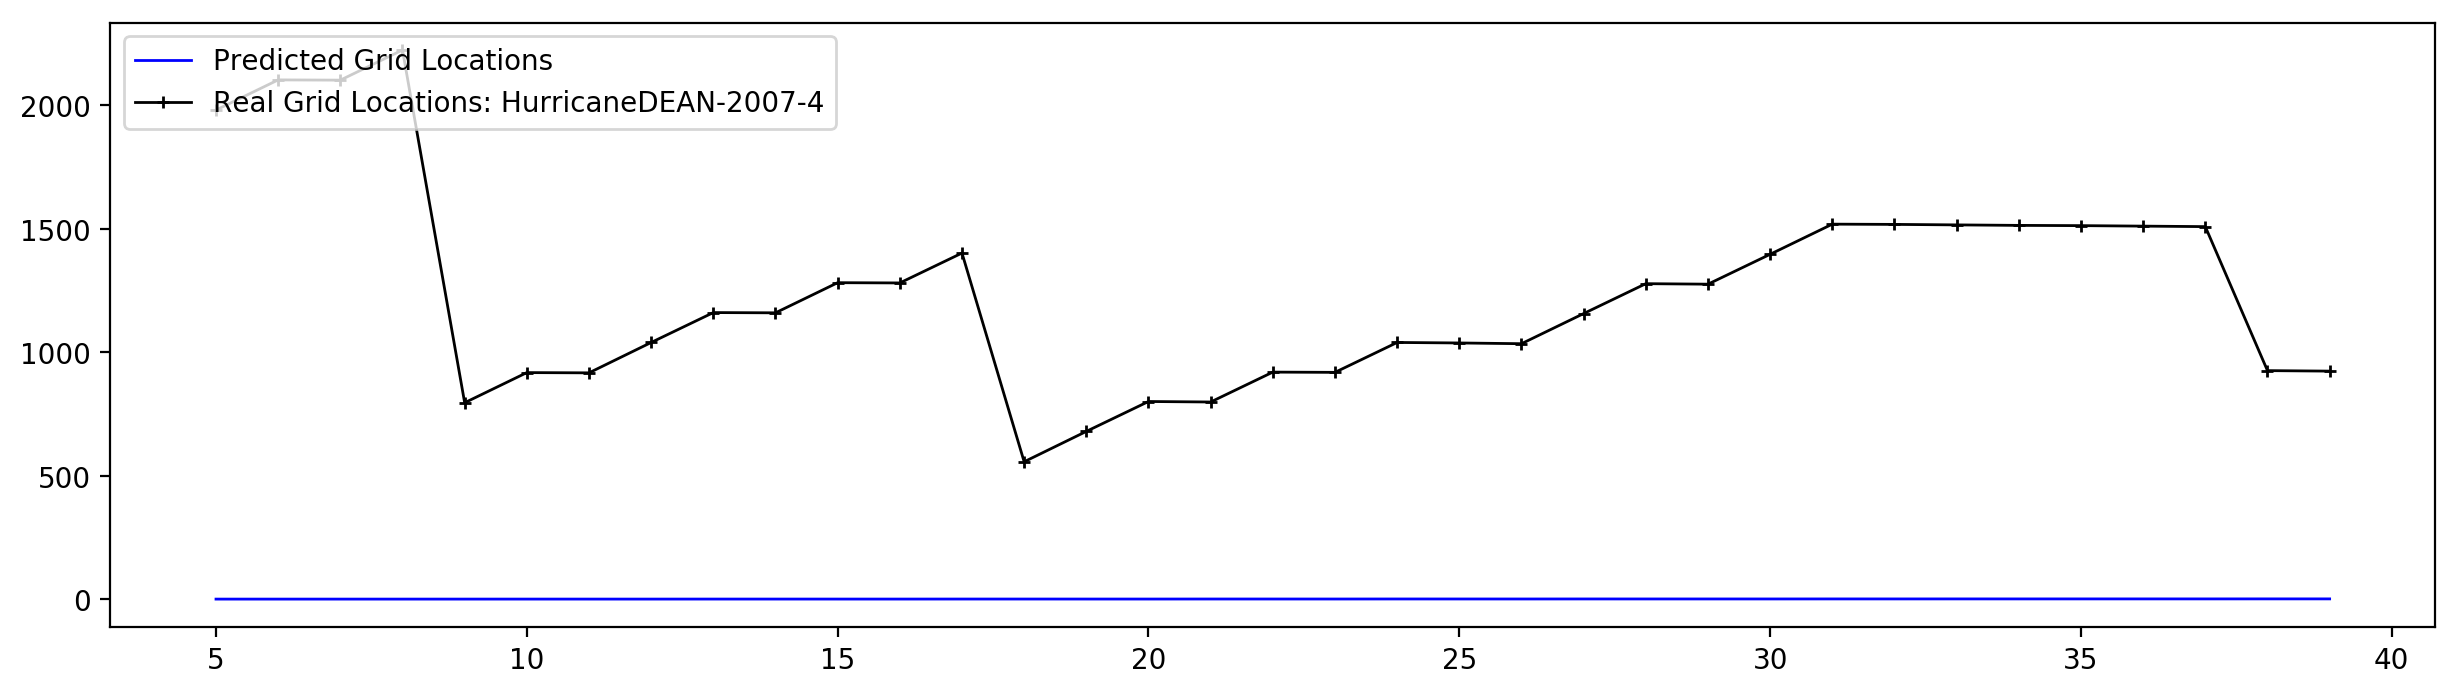

51
MAE:  1296.90182564


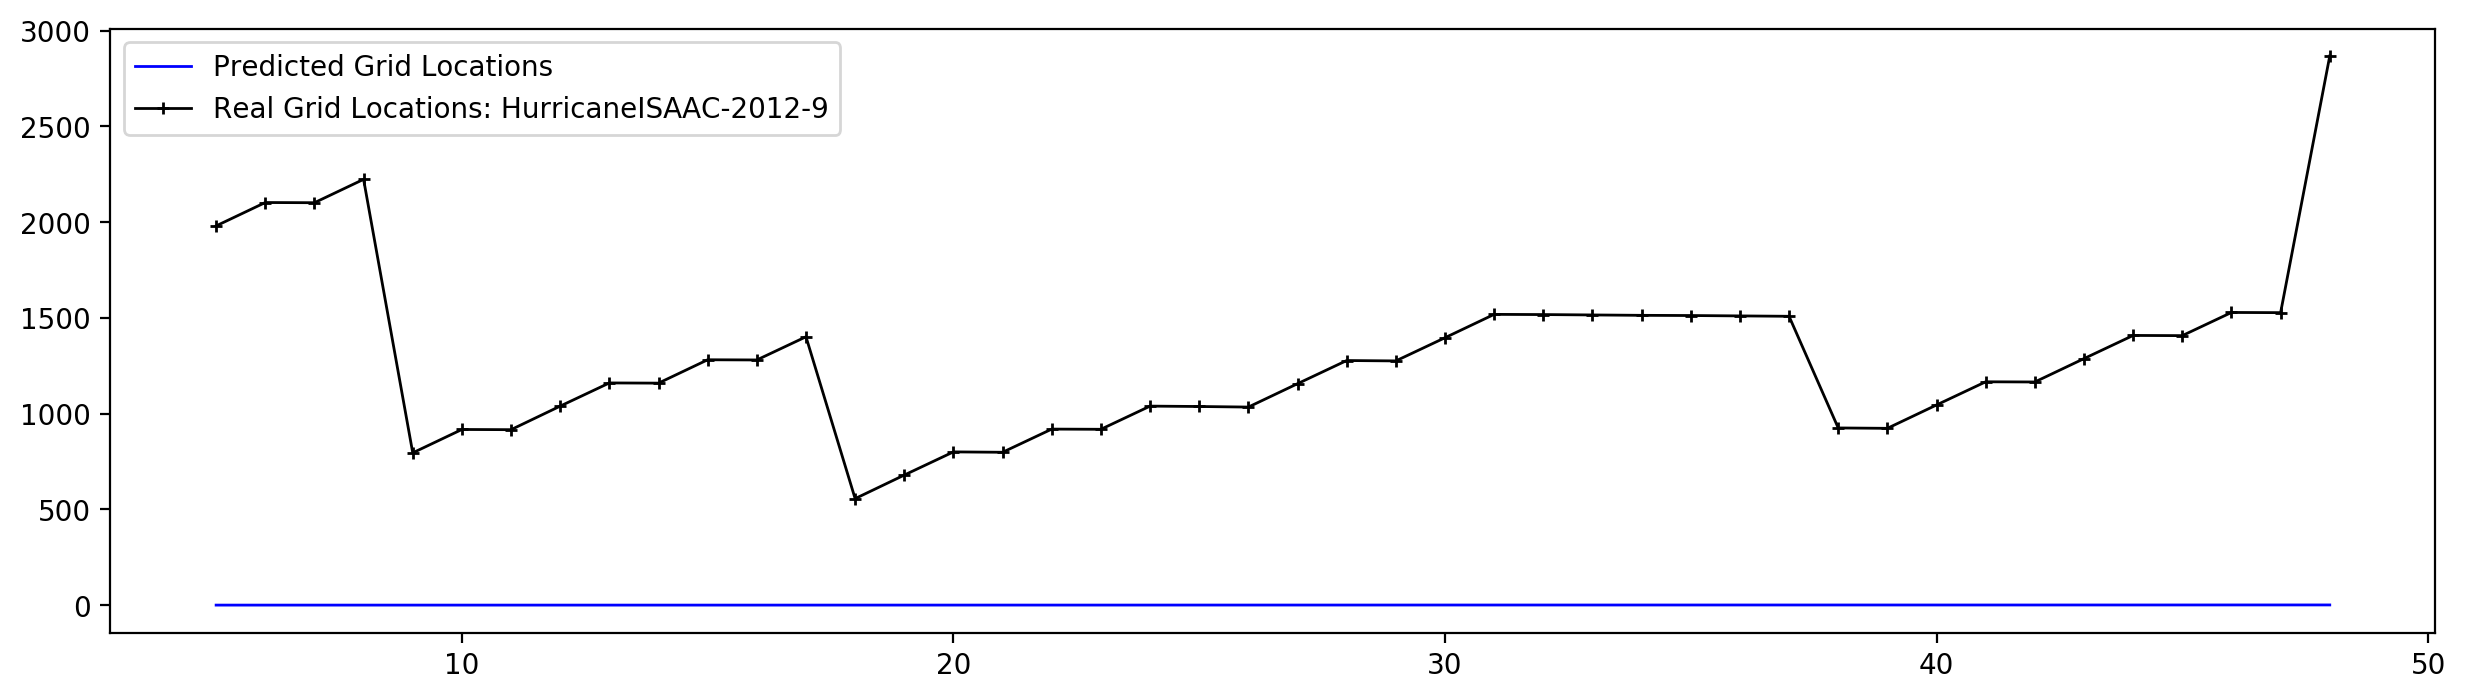

45
MAE:  1239.80490709


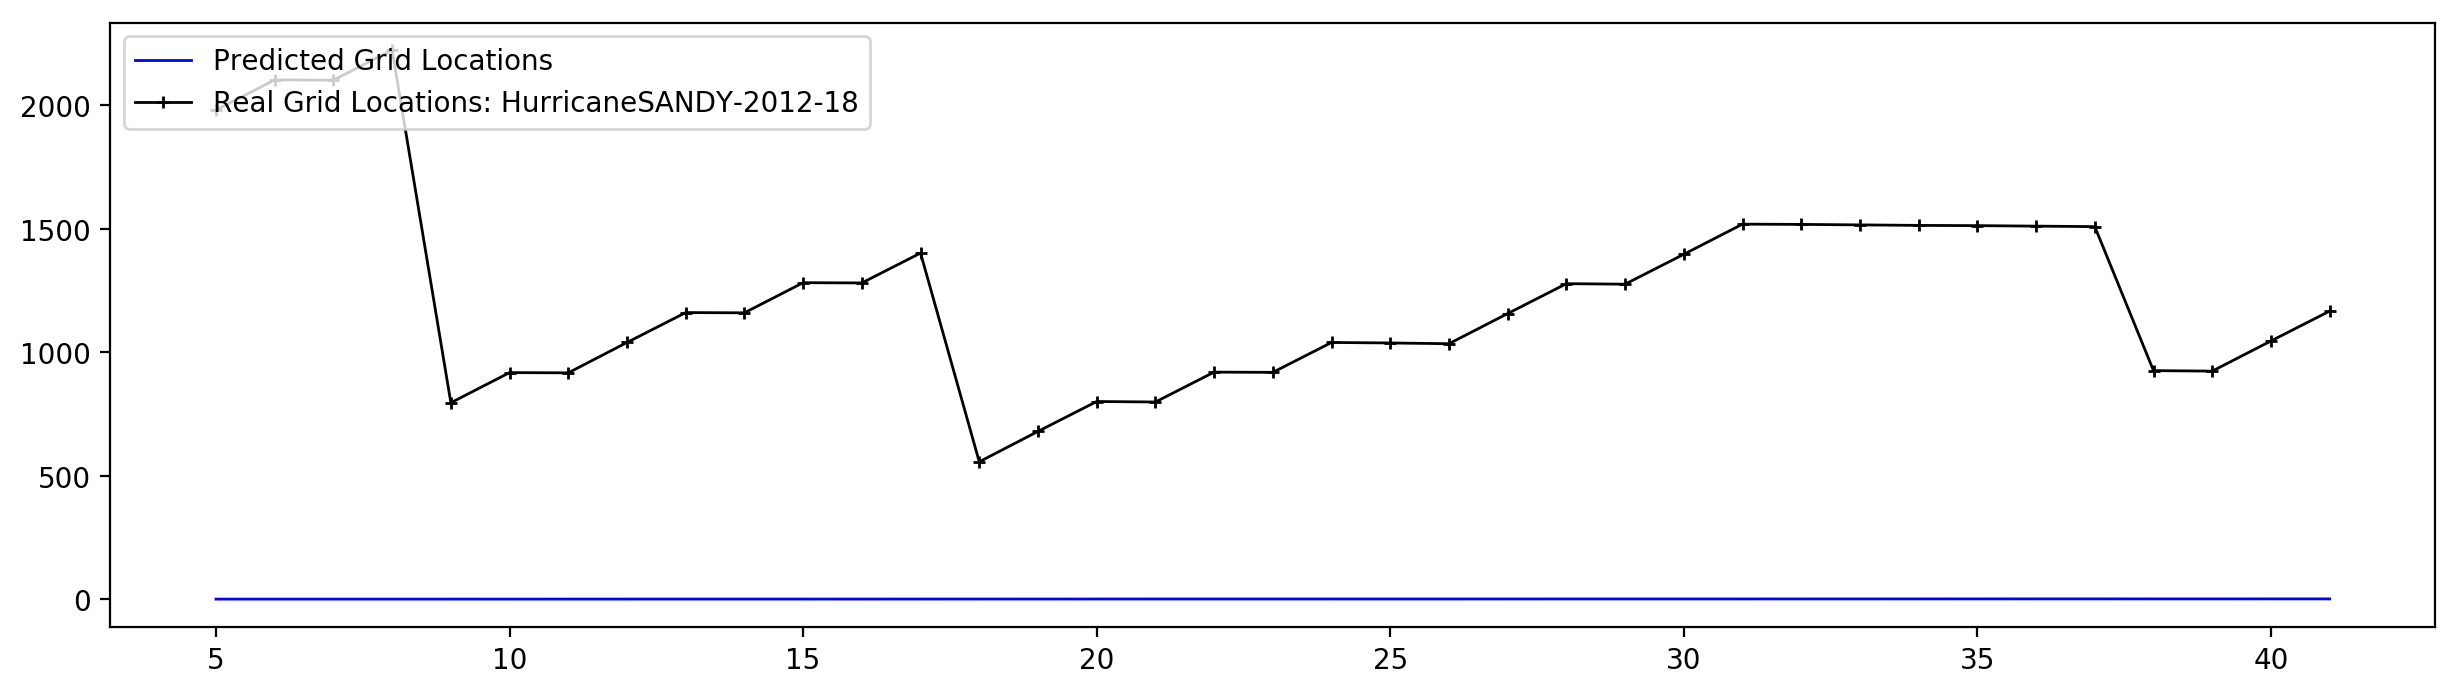

In [76]:
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error
import math

data = pd.read_csv('checkpoint-dataframe.csv', index_col=0) 
food = ['DEAN-2007', 'SANDY', 'ISAAC-2012']
names = [v for i, v in enumerate(data['unique-key'].unique()) if any(s in v for s in food)]

for x in names:
    name = x # Hurricane Key

    window = 5
    print (len(data[data['unique-key'] == name]))
    if len(data[data['unique-key'] == name]) < 10:
        continue
    hurricane = prep_hurricane(data[data['unique-key'] == name], name) # This is good
    hurr_data = load_hurricane(hurricane, window)
    pred = model.predict(hurr_data)
    hurricane_temp = data['gridID']
    hurricane_temp = hurricane_temp.reshape(-1, 1)

    y_pred = pred
    y = hurricane_temp[5: 5+len(pred)]

    print('MAE: ', mean_absolute_error(y, y_pred))
    plt.figure(figsize=(15, 4), dpi=100)
    plt.plot(list(np.arange(5,len(pred) + 5,1)), y_pred,
             linewidth=1, 
             color='blue', 
             label='Predicted Grid Locations')

    plt.plot(list(np.arange(5,len(pred) + 5,1)), y,
             linewidth=1, 
             color='black',
             marker='+',
             markersize=4,
             label='Real Grid Locations: Hurricane' + name)
    
    plt.legend(loc='upper left')
#     plt.savefig('grid_accuracy_one_hurr.png')
    plt.show()

In [55]:
model.summary()
model.get_config()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 5)           220       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 5)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 5)           220       
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 5)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 5)           220       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 5)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1)                 28        
__________

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, None, 5),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 0,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 5,
   'unroll': False,
   'us